In [2]:
import cv2 
from matplotlib import pyplot as plt 

In [3]:
def read_img(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    return img

# Calculate the points and matcher 

In [4]:
def show_img(img):
    plt.figure(figsize = (10,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [13]:
def matching_sift(img1, img2,n_features):
    # Starting the sift algorithm
    sift = cv2.xfeatures2d.SIFT_create(nfeatures =n_features)

    key_points_1,descriptors_1 = sift.detectAndCompute(img1,None)
    key_points_2,descriptors_2 = sift.detectAndCompute(img2,None)

    # Starting Brute force matcher between the key_points 
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)


    # applying the ratio test 
    good = []

    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    # Drawing the matches points  
    final_img = cv2.drawMatchesKnn(img1,key_points_1,img2,key_points_2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return final_img

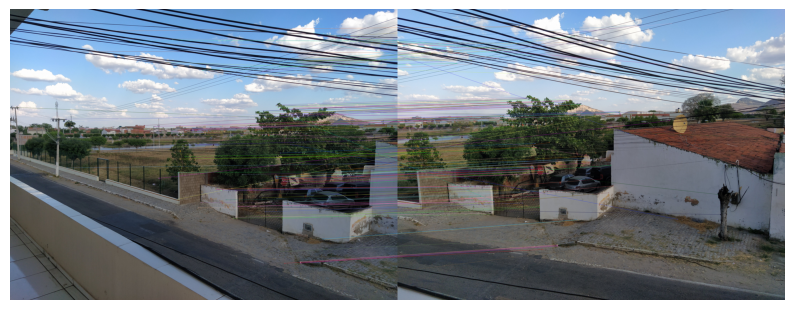

In [15]:
img_1 = read_img(r'C:\Users\richa\OneDrive\Documentos\Computer Vision\Computer-Vision-Course\Task_05\imagens\IMG_1.jpg')
img_2 = read_img(r'C:\Users\richa\OneDrive\Documentos\Computer Vision\Computer-Vision-Course\Task_05\imagens\IMG_2.jpg')

# Show image 
show_img(matching_sift(img_1,img_2, n_features =3000))